In [2]:
import anndata as ad
import scanpy as sc

import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
import torch
import os

from persist import PERSIST, ExpressionDataset

**Load and process dataset**

In [ ]:
basepath = '/storage/adult_brain_genes/sketches_gene_choice_scripts'

In [3]:
label = 'Clusters'
# see 00_data_proc.ipynb for details on how the .h5ad file was created
adata = sc.read(os.path.join(basepath, 'combined_sketches.h5ad'))
sc.pp.highly_variable_genes(adata)
# restrict to 10k highly variable genes
adata = adata[:,adata.var.highly_variable]

# convert categorical cell type labels to numbers
adata.obs[label] = pd.Categorical(adata.obs[label]).codes

# save binarized data in a separate layer
adata.layers['bin'] = (adata.X>0).astype(np.float32)

print(adata)

/tmp/ipykernel_3538685/4094860930.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[label] = pd.Categorical(adata.obs[label]).codes


AnnData object with n_obs × n_vars = 110000 × 4599
    obs: 'Age', 'Clusters', 'Subclusters', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'celltype', 'batch'
    var: 'mt', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'batch_colors', 'celltype_colors', 'hvg', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'bin'
    obsp: 'connectivities', 'distances'


**Create training and validation splits**

In [4]:
# Choose training and validation splits. 
# You may want to use a different strategy to choose these - see https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection
train_ind, val_ind = sk.model_selection.train_test_split(np.arange(adata.shape[0]), train_size=0.8)

print(f'{adata.shape[0]} total samples')
print(f'{np.size(train_ind)} in training set')
print(f'{np.size(val_ind)} in validation set')

# These are views, so they do not take up memory
adata_train = adata[train_ind,:]
adata_val = adata[val_ind,:]

110000 total samples
88000 in training set
22000 in validation set


**Run PERSIST**
 - Here the task is to select gene sets that can be used for cell type classification.
 - The reference is a scRNA-seq dataset, and the application might be selecting genes for an mFISH experiment where we want to recover cell type identity.
 - We choose input to be the binarized gene expression values to make results robust to domain shift (scRNA-seq vs. mFISH expression)
 - We use PERSIST with a cross entropy loss function, which is standard practice to train models for a classification problem. 

In [5]:
# Initialize the dataset for PERSIST
# Note: Here, data_train.layers['bin'] is a sparse array
# data_train.layers['bin'].A converts it to a dense array
train_dataset = ExpressionDataset(adata_train.layers['bin'].A, adata_train.obs[label])
val_dataset = ExpressionDataset(adata_val.layers['bin'].A, adata_val.obs[label])


# Use GPU device if available -- we highly recommend using a GPU!
device = torch.device(torch.cuda.current_device() if torch.cuda.is_available() else 'cpu')

# Number of genes to select within the current selection process.
num_genes = (500, 1000)
persist_results = {}

# Set up the PERSIST selector
selector = PERSIST(train_dataset,
                   val_dataset,
                   loss_fn=torch.nn.CrossEntropyLoss(),
                   device=device)

# Coarse removal of genes
print('Starting initial elimination...')
candidates, model = selector.eliminate(target=2000, max_nepochs=500)
print('Completed initial elimination.')



Starting initial elimination...
using CrossEntropyLoss, starting with lam = 0.0001


Training epochs:   0%|          | 0/500 [00:00<?, ?it/s]

lam = 0.000100 yielded 1448 genes
Reinitializing model for next iteration
next attempt is lam = 0.000060


Training epochs:   0%|          | 0/500 [00:00<?, ?it/s]

lam = 0.000060 yielded 2125 genes
done, lam = 0.000060 yielded 2125 genes
Completed initial elimination.


In [6]:
num_genes = [500, 1000]
print('Selecting specific number of genes...')
for num in num_genes:
    inds, model = selector.select(num_genes=num, max_nepochs=500)
    persist_results[num] = inds
print('Done')

Selecting specific number of genes...


Training epochs:   0%|          | 0/500 [00:00<?, ?it/s]

done, selected 500 genes


Training epochs:   0%|          | 0/500 [00:00<?, ?it/s]

done, selected 1000 genes
Done


In [7]:
# obtain a copy of features from the anndata object
# Note: Without the .copy(), you will modify adata itself, which may be desirable in some use cases.
df = adata.var.copy()

# set a boolean = True for genes selected in any of the rounds
for num in num_genes:
    df[f'persist_set_{num}'] = False
    ind = df.iloc[persist_results[num]].index
    df.loc[ind,f'persist_set_{num}'] = True

In [8]:
# only keep features (genes) that were selected in any set by PERSIST, and save for subsequent use
df = df[df[[f'persist_set_{num}' for num in num_genes]].any(axis=1)]

df.head(2)

,mt,highly_variable,means,dispersions,dispersions_norm,persist_set_500,persist_set_1000
AC092957.1,False,True,1.053561,3.147613,2.750493,True,True
RELN,False,True,1.165248,3.372329,3.219066,True,True


/home/amonell/miniconda3/envs/persist/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


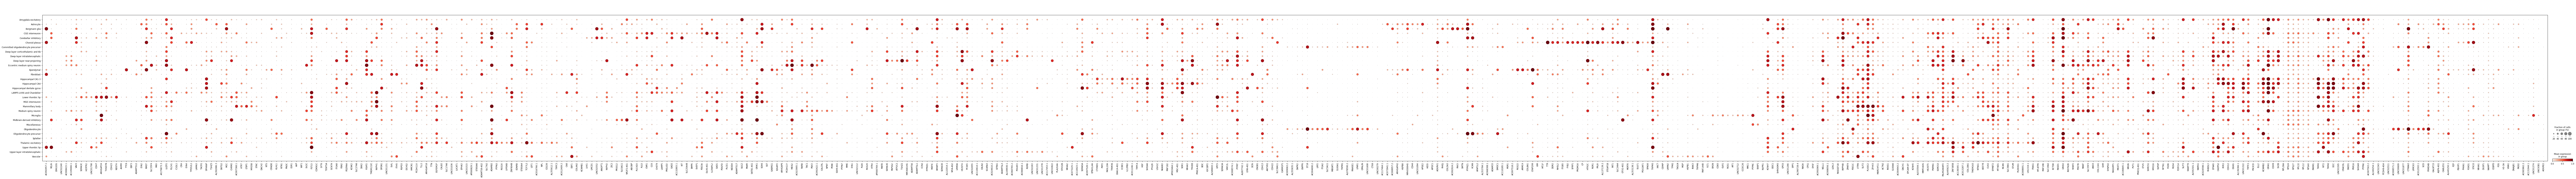

In [9]:
# Plot average binarized expression pattern for selection across cell types:
sc.pl.dotplot(adata,
              var_names=df[df['persist_set_500']].index.values,
              groupby='celltype',
              layer='bin')
plt.show()

In [14]:
pd.DataFrame(df[df['persist_set_500']].index.values).to_csv(os.path.join('persist_gene_list500.csv'))